In [10]:
import pandas as pd
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
mmscaler = MinMaxScaler()
sdscaler = StandardScaler()

In [4]:
import pickle as pkl

with open('/home/hb/python/efficientnet_kincnn/gradcam/gradcam_result.json', 'rb') as f:
    corr_matrix_dict = pkl.load(f)
corr_matrix_dict

{'flatten_gradcam': kinase      AAK1      ABL1      ABL2       ACK       ALK    AMPKa1    AMPKa2  \
 kinase                                                                         
 AAK1    1.000000 -0.300895 -0.262945 -0.097360 -0.357620 -0.134695  0.201811   
 ABL1   -0.300895  1.000000  0.862540  0.058284  0.174461  0.194317 -0.227903   
 ABL2   -0.262945  0.862540  1.000000 -0.003396  0.276105  0.116297 -0.202222   
 ACK    -0.097360  0.058284 -0.003396  1.000000 -0.145066  0.211089 -0.135807   
 ALK    -0.357620  0.174461  0.276105 -0.145066  1.000000  0.085910 -0.071327   
 ...          ...       ...       ...       ...       ...       ...       ...   
 p38b    0.146543  0.129971  0.043932  0.433264 -0.266729  0.062162 -0.226415   
 p38d    0.447061 -0.345737 -0.364308 -0.123183 -0.238565 -0.144088  0.348446   
 p38g    0.091995 -0.034446  0.063299 -0.061402 -0.122471 -0.220951  0.062663   
 skMLCK -0.061643  0.117063  0.093313  0.261748 -0.047831  0.099010  0.020426   
 smMLCK  

In [11]:
dd = pd.read_pickle("/home/hb/python/phospho/data/required/0308_final_train_test/dataset3.pkl")
kinmap = pd.read_csv("../kinase_family_kinmap.csv")
df = pd.read_pickle("grad_cam_result.pkl")
del df['grad_cam'], df['grad_cam_pp']
df.head(2)

# flatten_gradcam 정규화, 표준화 먼저
flatten_gradcam = np.array([x for x in df['flatten_gradcam']])
flatten_gradcam.shape
flatten_gradcam_mm = mmscaler.fit_transform(flatten_gradcam)
flatten_gradcam_sd = sdscaler.fit_transform(flatten_gradcam)

flatten_gradcam_mm = [x for x in flatten_gradcam_mm]
df['avg_gradcam_mm_bavg'] = flatten_gradcam_mm

flatten_gradcam_sd = [x for x in flatten_gradcam_sd]
df['avg_gradcam_sd_bavg'] = flatten_gradcam_sd

# # kinase 기준, groupby, mean
# family_gradcam = df.groupby("kinase").mean()
# family_gradcam['counts'] = df.kinase.value_counts(sort=False)

# origin_gradcam = family_gradcam['gradcam_b_avg']
# minmax_gradcam = family_gradcam['gradcam_minmax_b_avg']
# standard_gradcam = family_gradcam['gradcam_standard_b_avg']

# flatten_gradcam 평균 낸 후 정규화, 표준화 나중에
flatten_gradcam = np.array([x for x in df['flatten_gradcam']])

family_gradcam = df.groupby("kinase").mean()


minmax_gradcam = mmscaler.fit_transform([x for x in family_gradcam['flatten_gradcam']])
standard_gradcam = sdscaler.fit_transform([x for x in family_gradcam['flatten_gradcam']])

family_gradcam['avg_gradcam_mm_aavg'] = [x for x in minmax_gradcam]
family_gradcam['avg_gradcam_sd_aavg'] = [x for x in standard_gradcam]
family_gradcam['counts'] = df.kinase.value_counts(sort=False)

origin_gradcam = family_gradcam['flatten_gradcam']
minmax_gradcam_aavg = family_gradcam['avg_gradcam_mm_aavg']
standard_gradcam_aavg = family_gradcam['avg_gradcam_sd_aavg']

minmax_gradcam_bavg = family_gradcam['avg_gradcam_mm_bavg']
standard_gradcam_bavg = family_gradcam['avg_gradcam_sd_bavg']

In [20]:
_family = 'ALK'


In [37]:
df.head()

,pair,kinase,uniprotID,substrate,family,group,gradcam_resize,gradcam_pp_resize,flatten_gradcam,avg_gradcam_mm_bavg,avg_gradcam_sd_bavg
0,Q9UM73_RVCSLCYRELAAQ,ALK,Q9UM73,RVCSLCYRELAAQ,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0...","[[0.0205638, 0.05325572, 0.06773758, 0.1056384...","[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.04121449, 0.0, 0.0, 0.0...","[-0.38393033, -0.3828683, -0.39579064, -0.4014..."
1,Q9UM73_GLARDIYKDPDYV,ALK,Q9UM73,GLARDIYKDPDYV,ALK,TK,"[[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0,...","[[0.033400796, 0.0, 0.09327865, 0.0, 0.0822797...","[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0, ...","[0.0, 0.0063083945, 0.0, 0.013963076, 0.0, 0.0...","[-0.38393033, -0.16617994, -0.39579064, -0.189..."
2,Q9UM73_YRPSYSYDYEFDL,ALK,Q9UM73,YRPSYSYDYEFDL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.96...","[[0.0, 0.0, 0.0, 0.0, 0.11245741, 0.0, 0.11245...","[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.963...","[0.0, 0.0, 0.0, 0.0, 0.0043678046, 0.0, 0.0027...","[-0.38393033, -0.3828683, -0.39579064, -0.4014..."
3,P29376_RRAPELYRAPFPL,LTK,P29376,RRAPELYRAPFPL,ALK,TK,"[[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, ...","[[0.0625958, 0.0625958, 0.0625958, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, 0...","[0.0, 0.0, 0.0, 0.00076846854, 0.014146723, 0....","[-0.38393033, -0.3828683, -0.39579064, -0.3897..."
4,Q9UM73_KQVEELYHSLLEL,ALK,Q9UM73,KQVEELYHSLLEL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.0004413...","[[0.0, 0.109487526, 0.0, 0.114758596, 0.116214...","[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.00044131...","[0.0, 0.0, 0.0, 0.0, 0.048632465, 0.0426541, 0...","[-0.38393033, -0.3828683, -0.39579064, -0.4014..."


In [38]:
from itertools import permutations 
import scipy.stats as stats

in_group_cors_dict = {}
for _family in df['family'].unique():
    in_group_cors = []
    for _data1, _data2 in permutations(df[df['family']==_family]['avg_gradcam_sd_bavg'].to_list(), 2):
        in_group_cors.append(stats.pearsonr(_data1, _data2).statistic)
    in_group_cors_dict[_family] = in_group_cors

KeyboardInterrupt: 

In [56]:
in_group_cors_dict.keys()

dict_keys(['ALK', 'Abl', 'Ack', 'Aur', 'Axl', 'BUB', 'CAMK1', 'CAMK2', 'CAMKK', 'CAMKL', 'CASK'])

[Text(1, 0, 'ALK'),
 Text(2, 0, 'Abl'),
 Text(3, 0, 'Ack'),
 Text(4, 0, 'Aur'),
 Text(5, 0, 'Axl'),
 Text(6, 0, 'BUB'),
 Text(7, 0, 'CAMK1'),
 Text(8, 0, 'CAMK2'),
 Text(9, 0, 'CAMKK'),
 Text(10, 0, 'CAMKL'),
 Text(11, 0, 'CASK')]

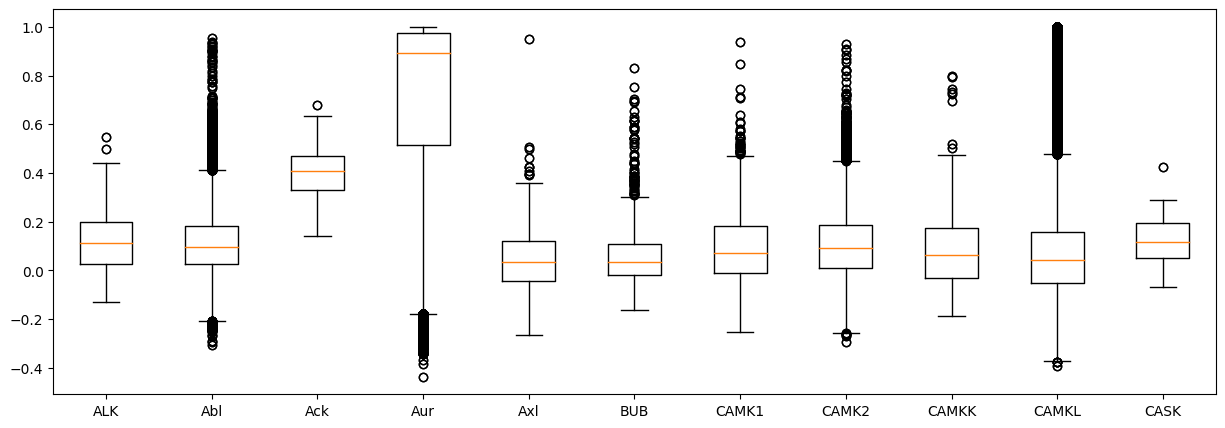

In [64]:
fig, ax = plt.subplots(figsize=(15,5))
# for i in in_group_cors_dict.keys():
#     print(len(in_group_cors_dict[i]))
x = [i for i in in_group_cors_dict.values()]
x_label = [x for x in in_group_cors_dict.keys()] 
ax.boxplot(x)
ax.set_xticklabels(x_label)
# ax.set_xlabel(x_label)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd03cfec850>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd03d373890>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd0fd6de010>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd0fd76b510>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd0fd769990>],
 'means': []}

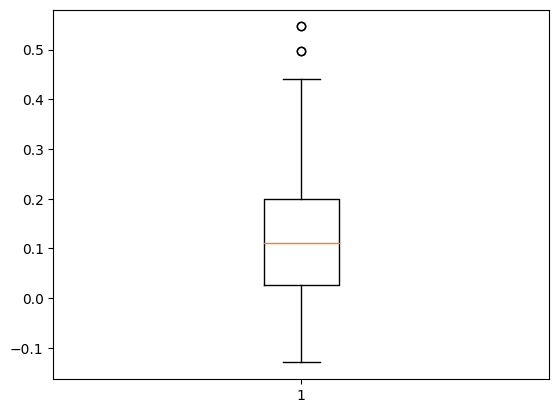

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot(in_group_cors)

In [29]:
import scipy.stats as stats

data1 = df[df['family']==_family]['avg_gradcam_sd_bavg'][0]
data2 = df[df['family']==_family]['avg_gradcam_sd_bavg'][1]

_cor = stats.pearsonr(data1, data2)
_cor

PearsonRResult(statistic=0.15661671801072263, pvalue=4.377064462152786e-23)

In [30]:
_cor.statistic

0.15661671801072263

In [18]:
pd.DataFrame(df.family.value_counts()).to_csv("family_counts.csv")

In [5]:
corr_matrix_dict['family_gradcam']

,gradcam_resize,gradcam_pp_resize,flatten_gradcam,avg_gradcam_mm_bavg,avg_gradcam_sd_bavg,avg_gradcam_mm_aavg,avg_gradcam_sd_aavg,counts,family
kinase,,,,,,,,,
AAK1,"[[0.0022991758, 0.00022196364, 0.0008329642, 0...","[[0.31718615, 0.0979229, 0.11910226, 0.1866089...","[0.0022991758, 0.00022196364, 0.0008329642, 0....","[0.14939082, 0.00995666, 0.07095721, 0.1728009...","[3.1084259, -0.040864963, 0.87434125, 2.217296...","[0.7455611978102972, 0.07993646200998251, 0.36...","[4.367759896668186, -0.4119993430381996, 0.994...",4,NAK
ABL1,"[[0.0003537328, 0.000356095, 0.00038298912, 0....","[[0.088302866, 0.07992635, 0.105065696, 0.0559...","[0.0003537328, 0.000356095, 0.00038298912, 0.0...","[0.022984063, 0.01597341, 0.03262545, 0.038312...","[0.15337561, 0.16580573, 0.18820421, 0.1791750...","[0.11470607710045722, 0.12824161076245336, 0.1...","[-0.09177897335113555, -0.055475280658582524, ...",435,Abl
ABL2,"[[0.00036397832, 0.00041052594, 0.0003376587, ...","[[0.07634758, 0.13708942, 0.09423148, 0.078557...","[0.00036397832, 0.00041052594, 0.0003376587, 0...","[0.023649784, 0.018415028, 0.02876393, 0.03343...","[0.16893817, 0.24967335, 0.11908274, 0.1052710...","[0.11802843086343712, 0.14784399768775155, 0.1...","[-0.0682931280919378, 0.08920334676386003, -0....",46,Abl
ACK,"[[0.0020614676, 0.000417504, 0.0010352691, 0.0...","[[0.19117703, 0.021165187, 0.06157365, 0.01748...","[0.0020614676, 0.000417504, 0.0010352691, 0.00...","[0.13394552, 0.018728044, 0.08819084, 0.067066...","[2.7473567, 0.26042515, 1.1828223, 0.61492646,...","[0.6684787852714954, 0.15035702504784904, 0.45...","[3.822861387284827, 0.10775115680962145, 1.469...",14,Ack
ALK,"[[0.00011874365, 0.00013986604, 7.9703656e-05,...","[[0.08338868, 0.87526417, 0.12160067, 0.435313...","[0.00011874365, 0.00013986604, 7.9703656e-05, ...","[0.0077154655, 0.006273993, 0.0067896666, 0.01...","[-0.20356344, -0.16736162, -0.27425578, -0.166...","[0.03850538824296322, 0.05037039598344935, 0.0...","[-0.6304445444570281, -0.6302165360413451, -0....",22,ALK
...,...,...,...,...,...,...,...,...,...
p38b,"[[0.00018686634, 0.0002773965, 0.00024977018, ...","[[0.99359393, 0.18716192, 0.080954365, 0.15231...","[0.00018686634, 0.0002773965, 0.00024977018, 0...","[0.012141789, 0.012443221, 0.021277022, 0.0308...","[-0.10008782, 0.044546444, -0.014932646, 0.065...","[0.06059575318111074, 0.09989967134141771, 0.1...","[-0.47428691355164065, -0.2646576067473265, -0...",54,MAPK
p38d,"[[0.00062115956, 0.00027893265, 0.0007142909, ...","[[0.111313045, 0.09260332, 0.14093402, 0.06865...","[0.00062115956, 0.00027893265, 0.0007142909, 0...","[0.040360343, 0.012512128, 0.06084786, 0.03557...","[0.55958617, 0.04691336, 0.6933842, 0.13768257...","[0.2014254239102713, 0.10045289288477144, 0.31...","[0.5212433913495015, -0.26057446453316857, 0.7...",38,MAPK
p38g,"[[0.00027695042, 0.00028133302, 0.00027255664,...","[[0.07179437, 0.0680864, 0.09399835, 0.5872873...","[0.00027695042, 0.00028133302, 0.00027255664, ...","[0.017995076, 0.0126198, 0.023218121, 0.015331...","[0.036746256, 0.05061184, 0.019813005, -0.1690...","[0.0898076105055364, 0.10131734478143399, 0.12...","[-0.2677871817952382, -0.25419423571927563, -0...",46,MAPK
